# Imports and Initializations

In [2]:
import numpy as np
import tensorflow as tf
import requests
import cv2
import os
import matplotlib.pyplot as plt
import shutil
import zipfile
import imageio
from tensorflow.keras.models import save_model
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
SEQUENCE_LENGTH = 30

# Loading Dataset 1 (UR Fall Detection Dataset)

Run Code Below if Downloading Dataset for the First Time:

In [ ]:
!mkdir camera_1_videos_fall
!mkdir camera_0_videos_fall
!mkdir adl_videos
!mkdir unzipped_camera_0_videos
!mkdir unzipped_camera_1_videos
!mkdir unzipped_adl_videos
!mkdir fall_tensors
!mkdir adl_tensors

In [ ]:
def download_file(url, local_filename):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    with open(local_filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

In [ ]:
def unzip_file(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

In [ ]:
def download_fall_videos():
  base_url = 'http://fenix.ur.edu.pl/~mkepski/ds/data/'
  for i in range(30):
    num_string = '0'+ str(i+1) if i+1 < 10 else str(i+1)
    cam0_url = base_url + 'fall-' + num_string + '-cam0-rgb.zip'
    cam1_url = base_url + 'fall-' + num_string + '-cam1-rgb.zip'
    download_file(cam0_url, '/content/camera_0_videos_fall/fall-' + num_string + '-cam0-rgb.zip')
    download_file(cam1_url, '/content/camera_1_videos_fall/fall-' + num_string + '-cam1-rgb.zip')
    unzip_file('/content/camera_0_videos_fall/fall-' + num_string + '-cam0-rgb.zip', '/content/unzipped_camera_0_videos')
    unzip_file('/content/camera_1_videos_fall/fall-' + num_string + '-cam1-rgb.zip', '/content/unzipped_camera_1_videos')

In [ ]:
def download_adl_videos():
    base_url = 'http://fenix.ur.edu.pl/~mkepski/ds/data/'
    for i in range(40):
      num_string = '0'+ str(i+1) if i+1 < 10 else str(i+1)
      adl_url = base_url + 'adl-' + num_string + '-cam0-rgb.zip'
      download_file(adl_url, '/content/adl_videos/adl-' + num_string + '-cam0-rgb.zip')
      unzip_file('/content/adl_videos/adl-' + num_string + '-cam0-rgb.zip', '/content/unzipped_adl_videos')

In [ ]:
download_fall_videos()
download_adl_videos()

In [ ]:
def find_split_num(length):
  return length // SEQUENCE_LENGTH

In [ ]:
def load_images_from_folder(folder,IMAGE_HEIGHT,IMAGE_WIDTH):
    images = []
    for i in range(len(os.listdir(folder))):
            num_string = '0'+ str(i+1) if i+1 < 10 else str(i+1)
            num_string = '0' + num_string if i+1<100 else str(i+1)
            end_part = folder.split('/')[-1]
            filename = folder +'/'+ end_part + '-' + num_string + '.png'
            img = cv2.imread(filename)
            img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
            img = img.astype('float32') / 255.0
            if img is not None:
                images.append(img)
    return images

In [ ]:
def array_to_mp4(array, output_file, fps=5):
    num_frames, height, width, channels = array.shape
    array = (array * 255).astype(np.uint8)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
    for i in range(num_frames):
        frame = array[i]
        video_writer.write(frame)
    video_writer.release()

In [ ]:
def video_to_frames(video_path):
    video_capture = cv2.VideoCapture(video_path)
    if not video_capture.isOpened():
        return
    frame_number = 0
    frame_list = []
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        frame_number += 1
        frame_list.append(frame)
    video_capture.release()
    return frame_list

In [ ]:
def split_array_by_num(arr):
  return arr[::find_split_num(len(arr))]

In [ ]:
for i in range(1,31):
  num_string = '0'+ str(i) if i < 10 else str(i)
  np.save('/content/fall_tensors/' + f"camera_0_{str(i)}", split_array_by_num(load_images_from_folder('/content/unzipped_camera_0_videos/fall-'+num_string+'-cam0-rgb',IMAGE_HEIGHT,IMAGE_WIDTH)))
  np.save('/content/fall_tensors/' + f"camera_1_{str(i)}", split_array_by_num(load_images_from_folder('/content/unzipped_camera_1_videos/fall-'+num_string+'-cam1-rgb',IMAGE_HEIGHT,IMAGE_WIDTH)))

In [ ]:
for i in range(1,41):
  num_string = '0'+ str(i) if i < 10 else str(i)
  np.save('/content/adl_tensors/' + f"adl_{str(i)}", split_array_by_num(load_images_from_folder('/content/unzipped_adl_videos/adl-'+num_string+'-cam0-rgb',IMAGE_HEIGHT,IMAGE_WIDTH)))

In [ ]:
def generate_video_dataset():
  dataset = tf.data.Dataset.from_tensor_slices(([np.load("/content/fall_tensors/camera_0_1.npy")], [1]))
  dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices(([np.load("/content/fall_tensors/camera_1_1.npy")], [1])))
  for i in range(2, 31):
    dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices(([np.load(f"/content/fall_tensors/camera_0_{i}.npy")], [1])))
    dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices(([np.load(f"/content/fall_tensors/camera_1_{i}.npy")], [1])))
    print("Fall", i)
  for i in range(1, 41):
    dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices(([np.load(f"/content/adl_tensors/adl_{i}.npy")], [0])))
    print("ADL", i)
  return dataset

In [ ]:
dataset1 = generate_video_dataset()

Run this if dataset is already downloaded to Drive

In [5]:
!mkdir Dataset1
!mkdir Dataset1/12321685308842595500
!mkdir Dataset1/12321685308842595500/00000000.shard
shutil.copy("/content/drive/MyDrive/Dataset/12321685308842595500/00000000.shard/00000000.snapshot", "/content/Dataset1/12321685308842595500/00000000.shard")
shutil.copy("/content/drive/MyDrive/Dataset/dataset_spec.pb", "/content/Dataset1")
shutil.copy("/content/drive/MyDrive/Dataset/snapshot.metadata", "/content/Dataset1")

dataset1 = tf.data.Dataset.load("/content/Dataset1")

# Loading Dataset 2 (IRO Multiple Cameras Fall Data Set)

Run Code Below if Downloading Dataset for the First Time:

In [ ]:
!curl -O https://www.iro.umontreal.ca/~labimage/Dataset/dataset.zip

In [ ]:
!unzip /content/dataset.zip

In [ ]:
def scale_and_resize_list_of_frames(frames):
  resized_frames = []
  for frame in frames:
    resized_frames.append(cv2.resize(frame,(128,128))/255.0)
  return resized_frames

In [ ]:
for i in range(1,20):
  numStr = f"0{i}" if i < 10 else str(i)
  l = video_to_frames(f'/content/dataset/chute{numStr}/cam1.avi')
  l_resized = scale_and_resize_list_of_frames(l)
  l_resized = l_resized[len(l_resized)//3:2*len(l_resized)//3]
  l_resized = split_array_by_num(l_resized)
  np.array(l_resized).shape
  np.save(f'/content/fall_videos/fall_video_{i}', np.array(l_resized))

In [ ]:
for i in range(23,25):
  for j in range(1,9):
    l = video_to_frames(f'/content/dataset/chute{i}/cam{j}.avi')
    l_resized = scale_and_resize_list_of_frames(l)
    l_resized = l_resized[len(l_resized)//3:2*len(l_resized)//3]
    l_resized = split_array_by_num(l_resized)
    np.array(l_resized).shape
    np.save(f'/content/non_fall_videos/non_fall_video_{(i - 23) * 23 + j}', np.array(l_resized))

In [ ]:
def generate_video_dataset():
  dataset = tf.data.Dataset.from_tensor_slices(([np.load("/content/fall_videos/fall_video_1.npy")], [1]))
  for i in range(2, 20):
    dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices(([np.load(f"/content/fall_videos/fall_video_{i}.npy")], [1])))
  for i in range(1, 17):
    dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices(([np.load(f"/content/non_fall_videos/non_fall_video_{i}.npy")], [0])))
  return dataset

In [ ]:
dataset2 = generate_video_dataset()

Run this if dataset is already downloaded to Drive:

In [6]:
# Dataset 2
!mkdir Dataset2
!mkdir Dataset2/16619387829981642527
!mkdir Dataset2/16619387829981642527/00000000.shard
shutil.copy("/content/drive/MyDrive/IRO_Dataset/16619387829981642527/00000000.shard/00000000.snapshot", "/content/Dataset2/16619387829981642527/00000000.shard")
shutil.copy("/content/drive/MyDrive/IRO_Dataset/dataset_spec.pb", "/content/Dataset2")
shutil.copy("/content/drive/MyDrive/IRO_Dataset/snapshot.metadata", "/content/Dataset2")

dataset2 = tf.data.Dataset.load("/content/Dataset2")

# Loading Dataset 3 (Mendeley CAUCAfall Dataset)

Run Code Below if Downloading Dataset for the First Time:

In [ ]:
!mkdir fall_tensors
!mkdir adl_tensors

In [ ]:
!curl -L -o CAUCAFall.zip "https://data.mendeley.com/public-files/datasets/7w7fccy7ky/4/files/CAUCAFall.zip"

In [ ]:
!unzip CAUCAFall.zip -d CAUCAFall

In [ ]:
falls = [r"Fall backwards", r"Fall forward", r"Fall left", r"Fall right", r"Fall sitting"]
adls = [r"Hop",r"Kneel", r"Pick up object", r"Sit down", r"Walk"]

In [ ]:
basePath = "/content/CAUCAFall"
fall_videos_list = []
non_fall_videos_list = []
for f in os.listdir(basePath):
  if "Subject" not in f:
    continue
  for fs in os.listdir(basePath + "/"+ f):
    if "DS" in fs:
      continue
    for fil in os.listdir(basePath + "/" + f + "/" + fs):
      if "Fall" in fs:
        if "avi" in fil[-4:]:
          frmList = scale_and_resize_list_of_frames(video_to_frames(basePath + "/" + f + "/" + fs + "/" + fil))
          frmList = split_array_by_num(frmList)
          np.save("/content/fall_tensors/" +fil, frmList)
      else:
        if "avi" in fil[-4:]:
          frmList = scale_and_resize_list_of_frames(video_to_frames(basePath + "/" + f + "/" + fs + "/" + fil))
          frmList = split_array_by_num(frmList)
          np.save("/content/adl_tensors/"  +fil, frmList)

In [ ]:
fallTensors = os.listdir("/content/fall_tensors")
dataset3 = tf.data.Dataset.from_tensor_slices(([np.load("/content/fall_tensors" + "/" +fallTensors[0])],[1]))
for f in fallTensors[1:]:
  dataset3 = dataset3.concatenate(tf.data.Dataset.from_tensor_slices(([np.load("/content/fall_tensors"+ "/"+ f)],[1])))
for f in os.listdir("/content/adl_tensors"):
  dataset3 = dataset3.concatenate(tf.data.Dataset.from_tensor_slices(([np.load("/content/adl_tensors" + "/" + f)],[0])))

Run this if dataset is already downloaded to Drive:

In [7]:
# Dataset 3
!mkdir Dataset3
!mkdir Dataset3/6637168987082036199
!mkdir Dataset3/6637168987082036199/00000000.shard
shutil.copy("/content/drive/MyDrive/Caucafall_Dataset/6637168987082036199/00000000.shard/00000000.snapshot", "/content/Dataset3/6637168987082036199/00000000.shard")
shutil.copy("/content/drive/MyDrive/Caucafall_Dataset/dataset_spec.pb", "/content/Dataset3")
shutil.copy("/content/drive/MyDrive/Caucafall_Dataset/snapshot.metadata", "/content/Dataset3")

dataset3 = tf.data.Dataset.load("/content/Dataset3")

# Loading Dataset 4 (UBFC Fall Detection Dataset)

Run Code Below if Downloading Dataset for the First Time:

In [ ]:
!unzip /content/drive/MyDrive/FallDataset/Coffee_room_01.zip

In [ ]:
!unzip /content/drive/MyDrive/FallDataset/Coffee_room_02.zip

In [ ]:
!unzip /content/drive/MyDrive/FallDataset/Home_01.zip

In [ ]:
!unzip /content/drive/MyDrive/FallDataset/Home_02.zip

In [ ]:
!unzip /content/drive/MyDrive/FallDataset/Office.zip

In [ ]:
def save_all_videos_as_np(in_directory):
  end_part = in_directory.split("/")[-3]
  os.mkdir("/content/"+ end_part+"_fall_tensors")
  base_dir = "/content/"+ end_part+"_fall_tensors/"
  # os.mkdir("/content"+ in_directory+"_fall_tensors")
  for e_file in os.listdir(in_directory):
    print(e_file)
    if e_file.endswith(".avi"):
      np.save(base_dir+e_file,scale_and_resize_list_of_frames(split_array_by_num(video_to_frames(in_directory+e_file))))

In [ ]:
save_all_videos_as_np("/content/Coffee_room_01/Videos/")

In [ ]:
save_all_videos_as_np("/content/Coffee_room_02/Videos/")

In [ ]:
save_all_videos_as_np("/content/Home_01/Videos/")

In [ ]:
save_all_videos_as_np("/content/Home_02/Videos/")

In [ ]:
save_all_videos_as_np("/content/Office/")

In [ ]:
def generate_dataset(in_directory, number_of_files):
    files = os.listdir(in_directory)
    dataset = tf.data.Dataset.from_tensor_slices(([np.load(in_directory+files[0])],[1]))
    for f in files[1:number_of_files]:
      dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices(([np.load(in_directory+f)],[1])))
    return dataset

In [ ]:
coffee_room_1_dataset = generate_dataset("/content/Coffee_room_01_fall_tensors/",7)
coffee_room_2_dataset = generate_dataset("/content/Coffee_room_02_fall_tensors/",7)
home_room_1_dataset = generate_dataset("/content/Home_01_fall_tensors/",7)
home_room_2_dataset = generate_dataset("/content/Home_02_fall_tensors/",7)
office_room_dataset = generate_dataset("/content/content_fall_tensors/",7)

In [ ]:
dataset4 = coffee_room_1_dataset.concatenate(coffee_room_2_dataset).concatenate(home_room_1_dataset).concatenate(home_room_2_dataset).concatenate(office_room_dataset)

Run this if dataset is already downloaded to Drive:

In [8]:
# Dataset 4
!mkdir Dataset4
!mkdir Dataset4/186375414934770863
!mkdir Dataset4/186375414934770863/00000000.shard
shutil.copy("/content/drive/MyDrive/UBFC_Dataset/186375414934770863/00000000.shard/00000000.snapshot", "/content/Dataset4/186375414934770863/00000000.shard")
shutil.copy("/content/drive/MyDrive/UBFC_Dataset/dataset_spec.pb", "/content/Dataset4")
shutil.copy("/content/drive/MyDrive/UBFC_Dataset/snapshot.metadata", "/content/Dataset4")

dataset4 = tf.data.Dataset.load("/content/Dataset4")

# Creating Combined Dataset

In [9]:
dataset2 = dataset2.map(lambda x, y: (tf.cast(x, tf.float32), y))
dataset3 = dataset3.map(lambda x, y: (tf.cast(x, tf.float32), y))
dataset4 = dataset4.map(lambda x, y: (tf.cast(x, tf.float32), y))
combined_dataset = dataset1.concatenate(dataset2).concatenate(dataset3).concatenate(dataset4)

In [10]:
combined_dataset.save("/content/Combined_Dataset")

In [11]:
dataset = tf.data.Dataset.load("/content/Combined_Dataset")

# Preprocessing Functions

In [12]:
def generate_train_test_val_splits(dataset,train_size,test_size,val_size):
  train_size = int(len(dataset)*train_size)
  test_size = int(len(dataset)*test_size)
  val_size = int(len(dataset)*val_size)
  dataset = dataset.shuffle(len(dataset))
  train_dataset = dataset.take(train_size)
  test_dataset = dataset.skip(train_size).take(test_size)
  val_dataset = dataset.skip(train_size+test_size).take(val_size)
  return train_dataset,test_dataset,val_dataset

In [13]:
def preprocess(sequence, label):
  sequence = sequence[:SEQUENCE_LENGTH]
  sequence = tf.pad(sequence, [[0, SEQUENCE_LENGTH - tf.shape(sequence)[0]], [0, 0], [0, 0], [0, 0]])
  return sequence, label

In [14]:
def prep_ds(dataset, batch_size=16):
  dataset = dataset.map(lambda x, y: (tf.image.resize(x, (IMAGE_HEIGHT, IMAGE_WIDTH)), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

# CNN and LSTM Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', AUC(), Precision(), Recall()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 30, 128, 128, 32   896       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 64, 64, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 30, 64, 64, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 30, 64, 64, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 30, 32, 32, 64)    0

Model Testing

In [17]:
train_ds, test_ds, val_ds = generate_train_test_val_splits(dataset, 0.7, 0.2, 0.1)

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

train_ds = prep_ds(train_ds)
val_ds = prep_ds(val_ds)
test_ds = prep_ds(test_ds)

start_time = time.process_time()
history = model.fit(train_ds, epochs=80, validation_data=val_ds)
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test AUC:", test_auc)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

start_time = time.process_time() - start_time
print("Time taken:", start_time)

Epoch 1/80
11/11 [==============================] - 7s 510ms/step - loss: 0.7708 - accuracy: 0.5771 - auc: 0.5280 - precision: 0.6410 - recall: 0.7009 - val_loss: 0.9015 - val_accuracy: 0.4000 - val_auc: 0.7433 - val_precision: 0.4000 - val_recall: 1.0000
Epoch 2/80
11/11 [==============================] - 3s 174ms/step - loss: 0.7058 - accuracy: 0.6000 - auc: 0.5468 - precision: 0.6327 - recall: 0.8532 - val_loss: 0.6153 - val_accuracy: 0.6800 - val_auc: 0.7831 - val_precision: 0.6800 - val_recall: 1.0000
Epoch 3/80
11/11 [==============================] - 3s 171ms/step - loss: 0.6755 - accuracy: 0.6229 - auc: 0.5637 - precision: 0.6596 - recall: 0.8378 - val_loss: 0.6273 - val_accuracy: 0.6400 - val_auc: 0.7596 - val_precision: 0.6250 - val_recall: 0.7692
Epoch 4/80
11/11 [==============================] - 3s 171ms/step - loss: 0.6155 - accuracy: 0.6457 - auc: 0.6871 - precision: 0.6754 - recall: 0.7549 - val_loss: 0.5008 - val_accuracy: 0.6800 - val_auc: 0.8373 - val_precision: 0.85

# Saving Figures and Model

In [18]:
def create_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    epochs = range(len(acc))

    # Plotting Accuracy
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.savefig('/content/Figures/accuracy.png')

    # Plotting Loss
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig('/content/Figures/loss.png')

    # Plotting AUC
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, auc, 'bo-', label='Training AUC')
    plt.plot(epochs, val_auc, 'ro-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()
    plt.savefig('/content/Figures/auc.png')

    # Plotting Precision
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, precision, 'bo-', label='Training Precision')
    plt.plot(epochs, val_precision, 'ro-', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    plt.savefig('/content/Figures/precision.png')

    # Plotting Recall
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, recall, 'bo-', label='Training Recall')
    plt.plot(epochs, val_recall, 'ro-', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()
    plt.savefig('/content/Figures/recall.png')

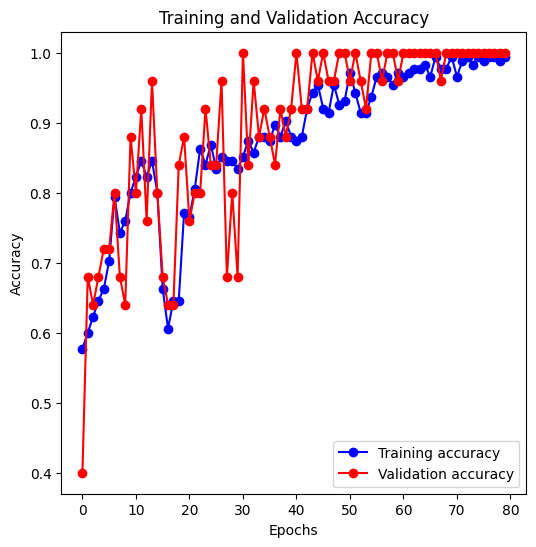

<Figure size 640x480 with 0 Axes>

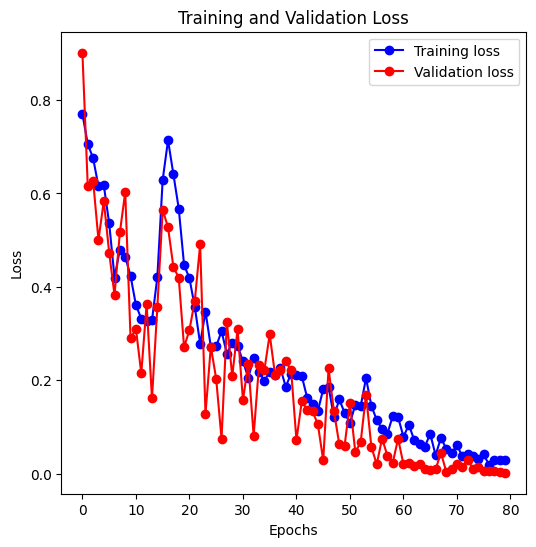

<Figure size 640x480 with 0 Axes>

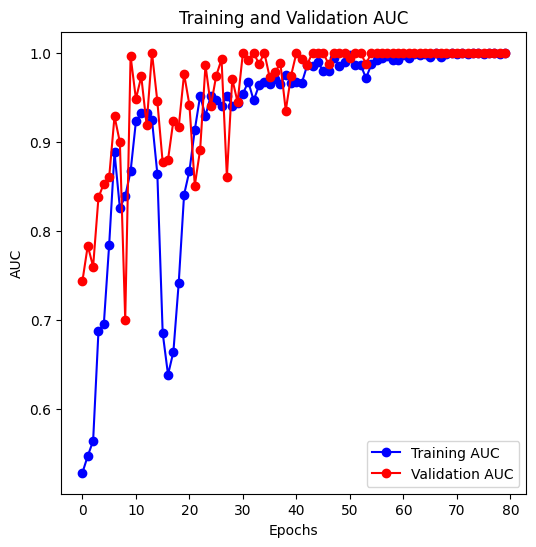

<Figure size 640x480 with 0 Axes>

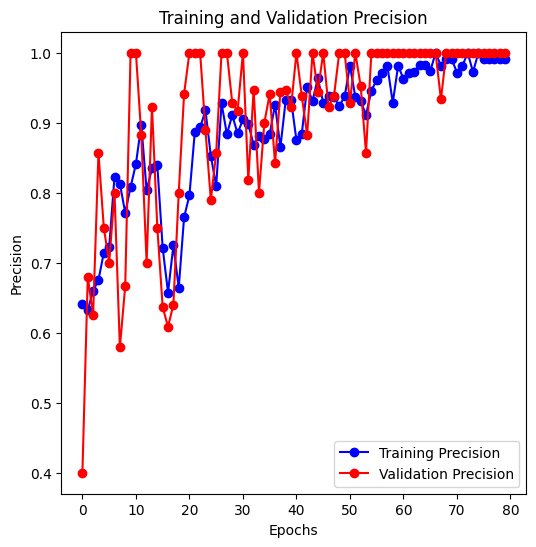

<Figure size 640x480 with 0 Axes>

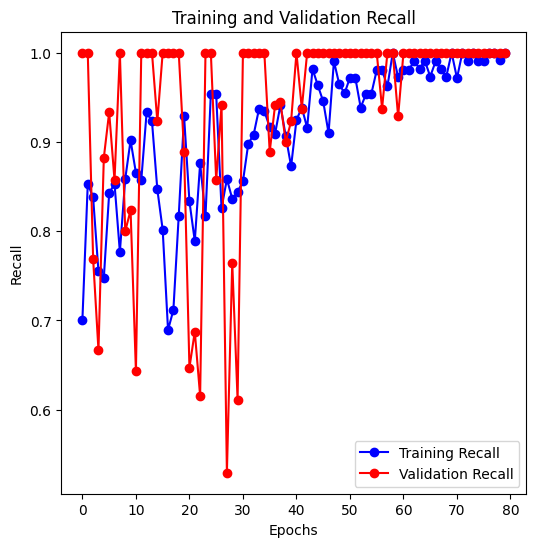

<Figure size 640x480 with 0 Axes>

In [19]:
create_plot(history)

In [20]:
save_model(model, 'my_model.h5')

<ipython-input-20-9db76e4b5ae4>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'my_model.h5')
